In [2]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
actions = [ # 액션을 각각 정의 
    'one', 'two', 'three', 'quit'
]

data = np.concatenate([ # 데이터를 로드해서 하나로 합침
    np.load('dataset/seq_one.npy'),
    np.load('dataset/seq_two.npy'),
    np.load('dataset/seq_three.npy'),
    np.load('dataset/seq_quit.npy')
], axis=0)

data.shape

(1196, 30, 100)

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1196, 30, 99)
(1196,)


In [5]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))   # 라벨을 이용하여 one-hot-encoding을 진행
y_data.shape

(1196, 4)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1076, 30, 99) (1076, 4)
(120, 30, 99) (120, 4)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 모델 정의
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 44,196
Trainable params: 44,196
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# 모델 학습 과정
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/test.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
31/34 [==========================>...] - ETA: 0s - loss: 4.5590e-07 - acc: 1.0000
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models\test.h5
34/34 [==============================] - 0s 9ms/step - loss: 4.2485e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000 - lr: 2.5000e-04
Epoch 2/200
30/34 [=========================>....] - ETA: 0s - loss: 4.6873e-07 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
34/34 [==============================] - 0s 8ms/step - loss: 4.2274e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000 - lr: 2.5000e-04
Epoch 3/200
29/34 [========================>.....] - ETA: 0s - loss: 2.6436e-07 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
34/34 [==============================] - 0s 9ms/step - loss: 4.2142e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000 - lr: 2.5000e-04
Epoch 4/200
29/34 [========================>.....] - ETA: 0s - loss: 4.4122e-07 - acc: 1.0000
Epoch 4: val_acc did 

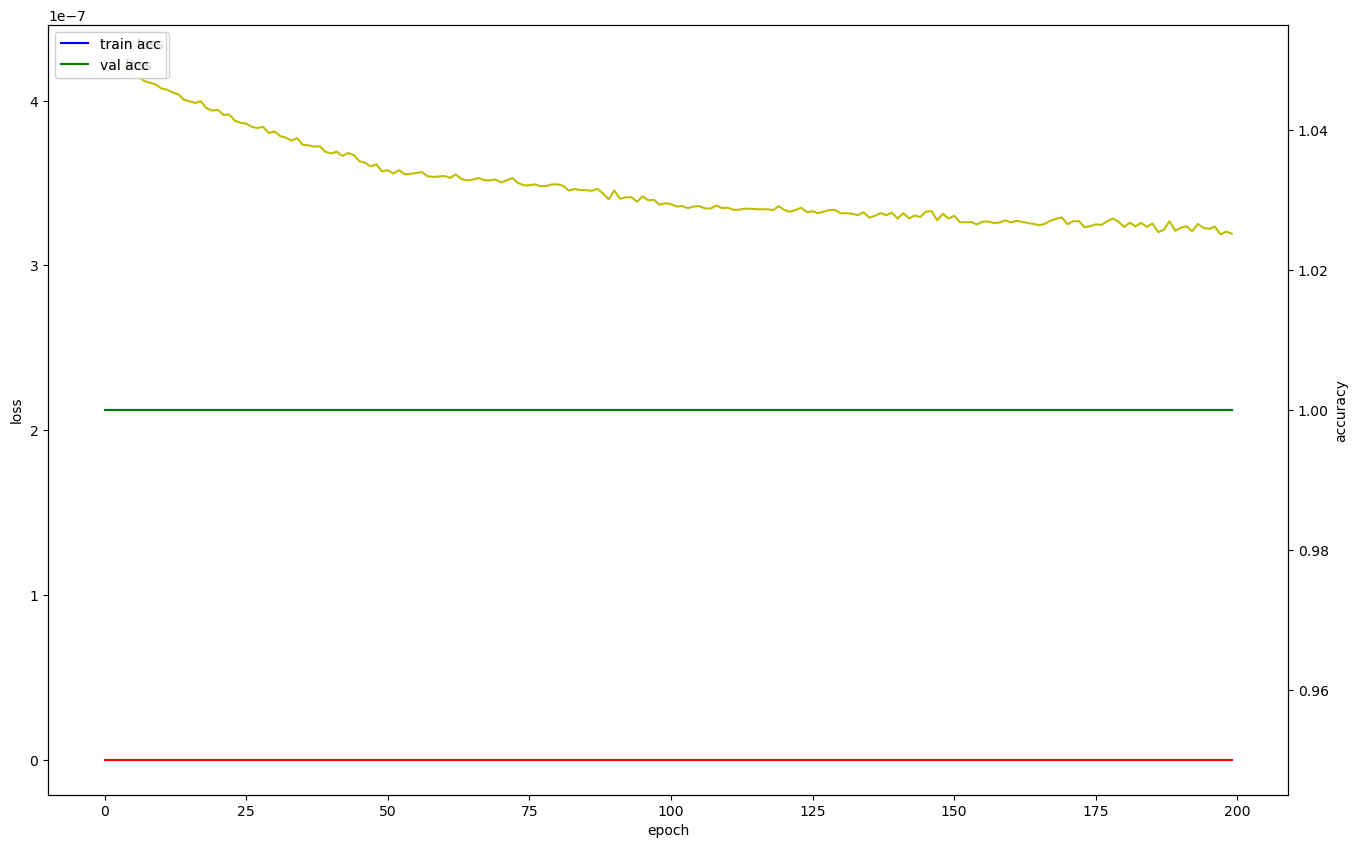

In [12]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/test.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

4/4 [==============================] - 0s 3ms/step


array([[[100,   0],
        [  0,  20]],

       [[101,   0],
        [  0,  19]],

       [[ 97,   0],
        [  0,  23]],

       [[ 62,   0],
        [  0,  58]]], dtype=int64)